In [1]:
__imp

Libraries have been loaded


## Load Additional Libraries

In [2]:
%reload_ext autoreload
%autoreload 2

from datetime import datetime

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

import lightgbm as lgb
from features import woe

basepath   = os.path.expanduser('../')

# train and validation fold
# TRAIN_PATH = os.path.join(basepath, 'data/processed/application_train_fold.feather')
# TEST_PATH  = os.path.join(basepath, 'data/processed/application_val_fold.feather')

# full training
TRAIN_PATH = os.path.join(basepath, 'data/processed/application_train.feather')
TEST_PATH  = os.path.join(basepath, 'data/processed/application_test.feather')

# MODEL PRESET
MODEL_PRESET   = 'M6'

## Load Processed Data

In [3]:
%%time

tr = pd.read_feather(f'{TRAIN_PATH}')
te = pd.read_feather(f'{TEST_PATH}')

# Application data from previous loans
bureau = pd.read_feather(os.path.join(basepath, 'data/processed/bureau.feather'))

CPU times: user 226 ms, sys: 127 ms, total: 353 ms
Wall time: 1.41 s


In [4]:
# concat training and test set
data   = pd.concat((tr, te))
ntrain = len(tr) 

del tr, te
gc.collect();

## Feature Engineering

In [5]:
%%time

# deviation in three external scores
data.loc[:, 'EXT_SOURCE_DEV']  = data.loc[:, ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].apply(np.std, axis=1)

# sum of external scores
data.loc[:, 'EXT_SOUCE_SUM'] = data['EXT_SOURCE_1'] + data['EXT_SOURCE_2'] + data['EXT_SOURCE_3']

# feature interactions
data.loc[:, 'EXT_3_1'] = data.loc[:, 'EXT_SOURCE_3'] / data.loc[:, 'EXT_SOURCE_1']
data.loc[:, 'EXT_3_2'] = data.loc[:, 'EXT_SOURCE_3'] / data.loc[:, 'EXT_SOURCE_2']
data.loc[:, 'EXT_2_1'] = data.loc[:, 'EXT_SOURCE_2'] / data.loc[:, 'EXT_SOURCE_1']

# relationship between amount credit and total income
data.loc[:, 'ratio_credit_income'] = data.loc[:, 'AMT_CREDIT'].map(np.log1p) / data.loc[:, 'AMT_INCOME_TOTAL'].map(np.log1p)

# relationship between annual amount to be paid and income
data.loc[:, 'ratio_annuity_income'] = data.loc[:, 'AMT_ANNUITY'] / data.loc[:, 'AMT_INCOME_TOTAL']

# number of missing values in an application
data.loc[:, 'num_missing_values'] = data.loc[:, data.columns.drop('TARGET')].isnull().sum(axis=1).values

# feature interaction between age and days employed
data.loc[:, 'age_plus_employed'] = data.loc[:, 'DAYS_BIRTH'] + data.loc[:, 'DAYS_EMPLOYED']

# previous loans
prev_loans = data.loc[:, ['SK_ID_CURR']].merge(bureau.loc[:, ['SK_ID_CURR', 
                                                              'CREDIT_ACTIVE', 
                                                              'DAYS_CREDIT',
                                                              'CREDIT_DAY_OVERDUE',
                                                              'DAYS_CREDIT_ENDDATE',
                                                              'AMT_CREDIT_MAX_OVERDUE',
                                                              'CNT_CREDIT_PROLONG',
                                                              'AMT_CREDIT_SUM'
                                                             ]], 
                                               on='SK_ID_CURR', 
                                               how='left')

# number of previous loans for a particular user
prev_num_loans = prev_loans.groupby('SK_ID_CURR').size()

# number of previous active credits
num_active_credits = prev_loans.groupby('SK_ID_CURR')['CREDIT_ACTIVE'].sum()

# mean days credit
mean_days_credit   = prev_loans.groupby('SK_ID_CURR')['DAYS_CREDIT'].mean()

# median days credit
median_days_credit = prev_loans.groupby('SK_ID_CURR')['DAYS_CREDIT'].median()

# std days credit
std_days_credit = prev_loans.groupby('SK_ID_CURR')['DAYS_CREDIT'].std()

# mean number of days overdue on any previous credit
mean_days_overdue = prev_loans.groupby('SK_ID_CURR')['CREDIT_DAY_OVERDUE'].mean()

# mean number of days of CB credit at the time of application
mean_days_credit_end = prev_loans.groupby('SK_ID_CURR')['DAYS_CREDIT_ENDDATE'].mean()

# mean of maximum amount overdue on any credit line
mean_max_amt_overdue = prev_loans.groupby('SK_ID_CURR')['AMT_CREDIT_MAX_OVERDUE'].mean()

# sum of num times credit was prolonged
sum_num_times_prolonged = prev_loans.groupby('SK_ID_CURR')['CNT_CREDIT_PROLONG'].sum()

# median of credit amount of different credit bureau loans
median_credit_amount = prev_loans.groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].sum()

# merge back with original dataframe
data.loc[:, 'num_prev_loans']           = data.SK_ID_CURR.map(prev_num_loans).fillna(0)
data.loc[:, 'num_prev_active_credits']  = data.SK_ID_CURR.map(num_active_credits).fillna(0)
data.loc[:, 'mean_days_credit']         = data.SK_ID_CURR.map(mean_days_credit).fillna(0)
data.loc[:, 'median_days_credit']       = data.SK_ID_CURR.map(median_days_credit).fillna(0)
data.loc[:, 'std_days_credit']          = data.SK_ID_CURR.map(std_days_credit).fillna(0)
data.loc[:, 'mean_credit_days_overdue'] = data.SK_ID_CURR.map(mean_days_overdue).fillna(0)
data.loc[:, 'mean_days_credit_end']     = data.SK_ID_CURR.map(mean_days_credit_end).fillna(0)
data.loc[:, 'mean_max_amt_overdue']     = data.SK_ID_CURR.map(mean_max_amt_overdue).fillna(0)
data.loc[:, 'sum_num_times_prolonged']  = data.SK_ID_CURR.map(sum_num_times_prolonged).fillna(0).astype(np.int8)
data.loc[:, 'median_credit_amount']     = data.SK_ID_CURR.map(median_credit_amount).fillna(0)

# delete all intermediatory variables
del prev_num_loans, num_active_credits, prev_loans
del mean_days_credit, median_days_credit
del std_days_credit, mean_days_overdue, mean_days_credit_end
del mean_max_amt_overdue, sum_num_times_prolonged

gc.collect();

CPU times: user 25.7 s, sys: 877 ms, total: 26.5 s
Wall time: 26.6 s


In [6]:
# replace feature values with frequency less 100 with -100
for f in data.select_dtypes(include=['int8']).columns:
    if data[f].nunique() > 10:        
        low_freq_values = data[f].value_counts()
        low_freq_values = low_freq_values[low_freq_values < 100].index.values
        
        if len(low_freq_values) > 0:
            print('Feature: {}'.format(f))
            data.loc[data[f].isin(low_freq_values), f] = -100

Feature: CNT_CHILDREN
Feature: HOUR_APPR_PROCESS_START
Feature: ORGANIZATION_TYPE


In [7]:
# unpack to train and test
tr = data.iloc[:ntrain]
te = data.iloc[ntrain:]

del data
gc.collect();

## Modelling

In [8]:
COLS_TO_REMOVE = [
                  'FLAG_DOCUMENT_21',
                  'FLAG_DOCUMENT_4',
                  'FLAG_MOBIL',
                  'FLAG_DOCUMENT_2',
                  'FLAG_DOCUMENT_20',
                  'FLAG_DOCUMENT_9',
                  'FLAG_DOCUMENT_17',
                  'FLAG_DOCUMENT_19',
                  'FLAG_CONT_MOBILE',
                  'FLAG_DOCUMENT_10',
                  'HOUSETYPE_MODE',
                  'FLAG_DOCUMENT_12',
                  'FLAG_DOCUMENT_7',
                  'SK_ID_CURR',
                  'TARGET'
                ]

In [9]:
features = [f for f in tr.columns if f not in COLS_TO_REMOVE]

Xtr  = tr.loc[:, features]
ytr  = tr.loc[:, 'TARGET']

Xval = te.loc[:, features]
# yval = te.loc[:, 'TARGET'] # only execute during validation phase

In [10]:
print('Number of features used in the model are: {}'.format(len(features)))

Number of features used in the model are: 126


### Validation

In [11]:
params = {
    'objective': 'binary',
    'learning_rate': .02,
    'metric': 'auc',
    'min_data_in_leaf': 100,
    'num_leaves': 31,
    'feature_fraction': .7,
    'bagging_fraction': .8,
    'min_child_weight': 1.,
    'nthread': 4
}

ltrain = lgb.Dataset(Xtr, ytr, feature_name=features)
lval   = lgb.Dataset(Xval, yval, feature_name=features)

valid_sets  = [ltrain, lval]
valid_names = ['train', 'val']

num_boost_round       = 5000
early_stopping_rounds = 100

m = lgb.train(params, 
              ltrain, 
              num_boost_round, 
              valid_sets=valid_sets, 
              valid_names=valid_names, 
              early_stopping_rounds=early_stopping_rounds, 
              verbose_eval=20)

Training until validation scores don't improve for 100 rounds.
[20]	train's auc: 0.732826	val's auc: 0.725712
[40]	train's auc: 0.735745	val's auc: 0.728026
[60]	train's auc: 0.738976	val's auc: 0.730751
[80]	train's auc: 0.741832	val's auc: 0.732589
[100]	train's auc: 0.744783	val's auc: 0.735112
[120]	train's auc: 0.747842	val's auc: 0.737565
[140]	train's auc: 0.751299	val's auc: 0.740086
[160]	train's auc: 0.754749	val's auc: 0.742391
[180]	train's auc: 0.758526	val's auc: 0.745096
[200]	train's auc: 0.762473	val's auc: 0.747943
[220]	train's auc: 0.76625	val's auc: 0.750499
[240]	train's auc: 0.769755	val's auc: 0.752648
[260]	train's auc: 0.772793	val's auc: 0.75422
[280]	train's auc: 0.775756	val's auc: 0.755673
[300]	train's auc: 0.778532	val's auc: 0.756838
[320]	train's auc: 0.781105	val's auc: 0.757727
[340]	train's auc: 0.783599	val's auc: 0.758409
[360]	train's auc: 0.785915	val's auc: 0.758994
[380]	train's auc: 0.788223	val's auc: 0.759502
[400]	train's auc: 0.790472	val

`[1015]	train's auc: 0.841095	val's auc: 0.763451`

### Feature Importance

In [12]:
# feature importance df
feat_imp = pd.DataFrame({'features': features,
                         'imp': m.feature_importance()
                        })

feat_imp.sort_values(by='imp', ascending=False)

,features,imp
37,EXT_SOURCE_2,1474
38,EXT_SOURCE_3,1305
36,EXT_SOURCE_1,1150
22,DAYS_BIRTH,973
1,AMT_CREDIT,920
2,AMT_GOODS_PRICE,898
0,AMT_ANNUITY,877
23,DAYS_EMPLOYED,823
108,EXT_SOUCE_SUM,773
24,DAYS_ID_PUBLISH,766


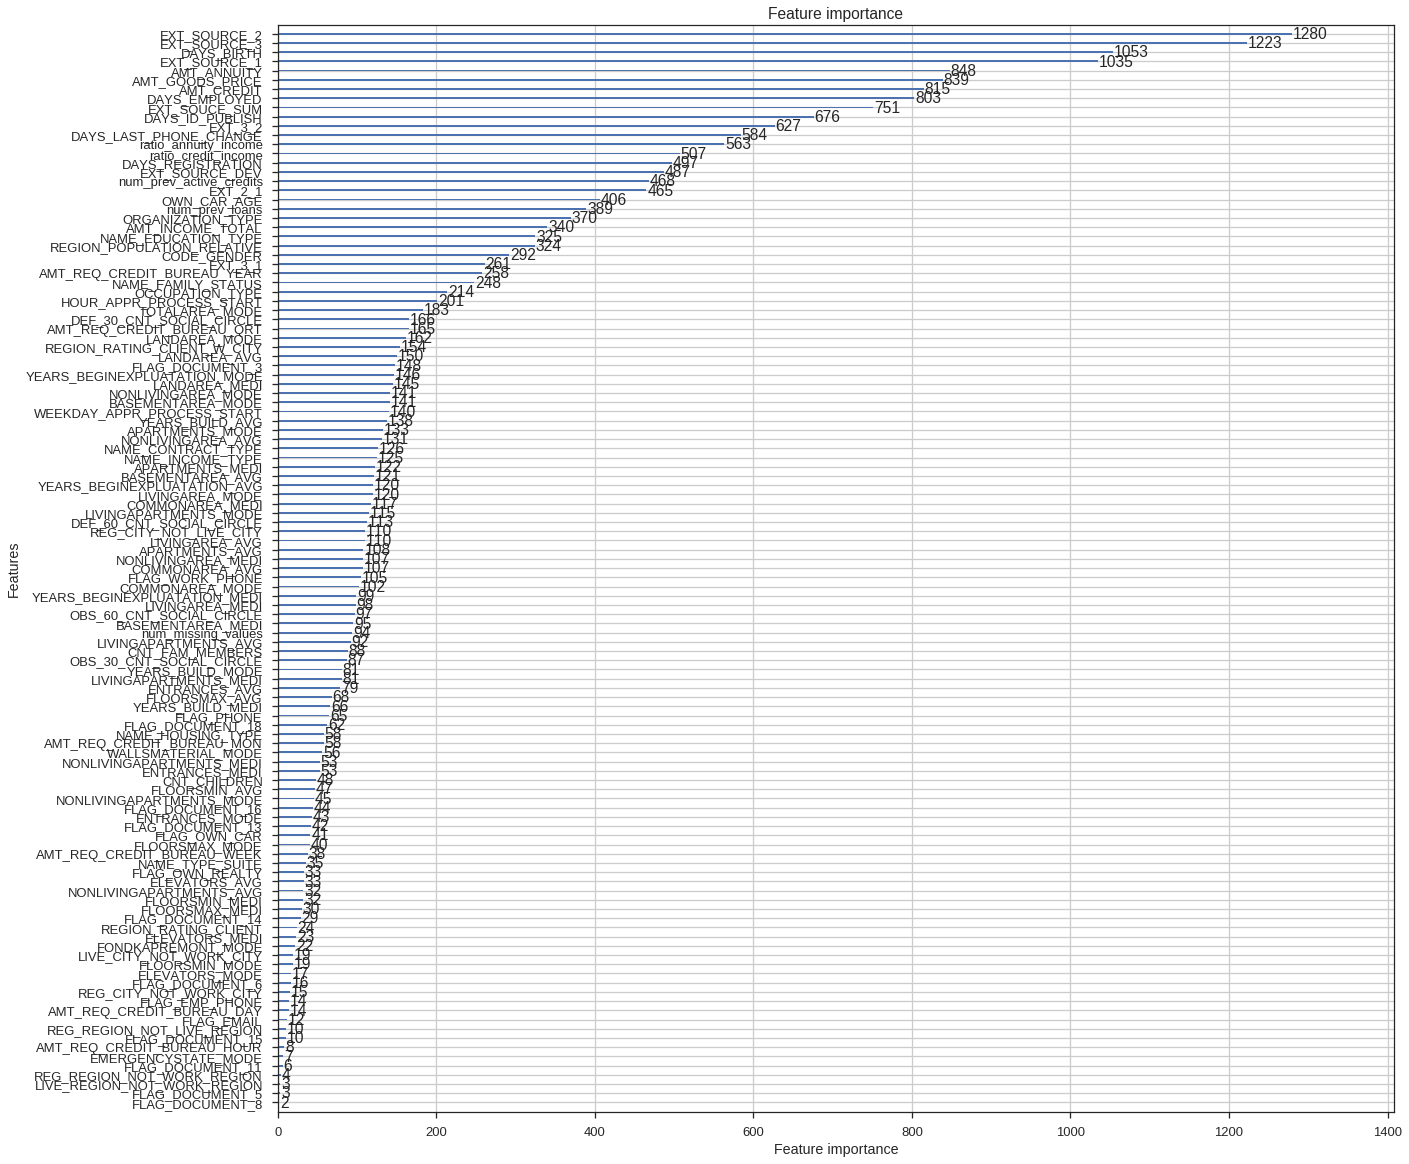

In [12]:
fig, ax = plt.subplots(1, figsize=(20, 20))
lgb.plot_importance(m, ax=ax);

### OOF Predictions

In [18]:
%%time

HOLDOUT_SCORE  = 0.763451

oof_preds = m.predict(Xval)
joblib.dump(oof_preds, os.path.join(basepath, f'data/oof_sub/{MODEL_PRESET}_{HOLDOUT_SCORE}_preds.pkl'))

CPU times: user 7.74 s, sys: 36.1 ms, total: 7.78 s
Wall time: 2.21 s


### Full Training

In [11]:
%%time

params = {
    'objective': 'binary',
    'learning_rate': (.02 / 1.2),
    'metric': 'auc',
    'min_data_in_leaf': 100,
    'num_leaves': 31,
    'feature_fraction': .7,
    'bagging_fraction': .8,
    'min_child_weight': 1.,
    'nthread': 4
}

BEST_ITERATION = 1015

num_boost_round = int(BEST_ITERATION * 1.2)
ltrain = lgb.Dataset(Xtr, ytr, feature_name=features)

m           = lgb.train(params, ltrain, num_boost_round)
final_preds = m.predict(Xval)

CPU times: user 9min 37s, sys: 2.69 s, total: 9min 40s
Wall time: 2min 44s


In [12]:
HOLDOUT_SCORE  = 0.763451

sub_identifier = "%s-%s-%.5f" % (datetime.now().strftime('%Y%m%d-%H%M'), MODEL_PRESET, HOLDOUT_SCORE)

sub           = pd.read_csv('../data/raw/sample_submission.csv.zip')
sub['TARGET'] = final_preds

sub.to_csv(os.path.join(basepath, 'submissions/%s.csv'%(sub_identifier)), index=False)